#### coherenecy of geolocation of MCS initiation and that of high-BL regimes
- whether frequent high BL in a place actually bosters more MCS initialized there
- writeout scripts: 'MCScounts_initial_map_writeout.py'; 'BLcounts_criticalval_map_writeout.py'

In [3]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy.stats import linregress

import warnings

In [4]:
warnings.filterwarnings('ignore')

In [5]:
# # set fonts configuration - Arial
# matplotlib.rcParams['font.family'] = "Open Sans"
# matplotlib.rcParams['font.sans-serif'] = "Arial"

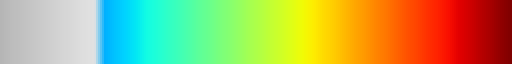

In [41]:
colors1 = plt.cm.Greys_r(np.linspace(0.6, 0.8, 10))
colors2 = plt.cm.jet(np.linspace(0.3, 1, 40))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

##### Buoyancy measure, BL mean values

##### MCS frequency and fraction of BL Critical

In [7]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/MCScounts_map')
files = sorted(list(out_dir.glob('*.nc')))
data_merged = []
for file in files:
    data = xr.open_dataset(file)
    data_merged.append(data)
data_merged = xr.concat(data_merged, pd.Index(np.arange(2002,2015), name='year'))
MCScounts = data_merged.counts

Text(0.5, 1.0, 'Fraction of time associated with MCS, 2002-2014')

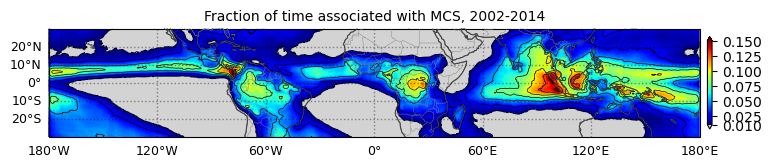

In [8]:
# out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/')
# ds_MCSfreq = xr.open_dataset(out_dir / 'MCScounts_map_initial_3hrly.2002.2014.nc')

fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'k'}
gl.ylabel_style = {'size': 9, 'color': 'k'}

# plot seasonal mean of BL_TOT as background
cp = ax.pcolormesh(MCScounts.lon, MCScounts.lat, MCScounts.sum(('year','month'))/(13*24*365), vmin=0.01, vmax=0.15, cmap='jet'
                   , transform=ccrs.PlateCarree())
cf = ax.contour(MCScounts.lon, MCScounts.lat, MCScounts.sum(('year','month'))/(13*24*365), levels=[0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15],
           linewidths=0.5, colors=['k'], transform=ccrs.PlateCarree())
cp.cmap.set_under('lightgrey')
cbar = plt.colorbar(cp, ax=ax, shrink=0.4, pad=0.01, extend='both')
#ax.clabel(cf, inline=True, fontsize=6)
cbar.set_ticks([0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15])

ax.set_title('Fraction of time associated with MCS, 2002-2014',fontsize=10)
#fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCS_fractionoftimes.2002.2014.pdf',
#           bbox_inches='tight', transparent=False)

In [9]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/')
ds_exceedBLfreq = xr.open_dataset(out_dir / 'counts_map_BLcritval_3hrly.2002.2014.update.nc')

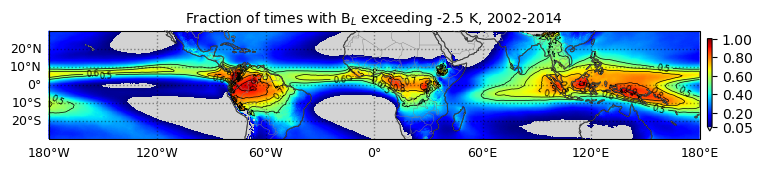

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree()})

total_times = 8*365*13 # 3-hourly, days, 13 years

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'k'}
gl.ylabel_style = {'size': 9, 'color': 'k'}

# plot seasonal mean of BL_TOT as background
cp = ax.pcolormesh(ds_exceedBLfreq.lon, ds_exceedBLfreq.lat, ds_exceedBLfreq.counts.sum(('year','month'))/total_times,
                 vmin=0.05, vmax=1,
           cmap='jet', transform=ccrs.PlateCarree())
cf = ax.contour(ds_exceedBLfreq.lon, ds_exceedBLfreq.lat, ds_exceedBLfreq.counts.sum(('year','month'))/total_times,
               levels=np.arange(0.5,1.1,0.1), colors=['k'], linewidths=0.5, transform=ccrs.PlateCarree())
ax.clabel(cf, inline=True, fontsize=6)

cp.cmap.set_under('lightgrey')
cbar = plt.colorbar(cp, ax=ax, shrink=0.4, pad=0.01, extend='min')
cbar.set_ticks([0.05, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_title('Fraction of times with B$_{L}$ exceeding -2.5 K, 2002-2014', fontsize=10);

fig.savefig('/scratch/wmtsai/temp_mcs/fig/BLcrit_exceed5K_fractionoftimes.n25K.pdf', 
          bbox_inches='tight', transparent=False)

In [11]:
# get land-sea mask 0.25-degree 
data_landsea = xr.open_dataset('/scratch/wmtsai/temp_mcs/output_stats/ERA5_LandSeaMask_regrid.nc4')
landsea_mask = data_landsea.landseamask
landsea_mask = landsea_mask.rename({'longitude': 'lon', 'latitude': 'lat'})
landsea_regrid = landsea_mask.interp(lon=ds_exceedBLfreq.lon, lat=ds_exceedBLfreq.lat)

In [22]:
# histogram of spatial distribution of BL-fraction states over land and oceans
BLF_values = ds_exceedBLfreq.counts/total_times

bins_BLF = np.arange(0,1,0.025)
dist_BLF_land = np.zeros((len(bins_BLF)-1))
dist_BLF_ocean = np.copy(dist_BLF_land)

BLF_land = BLF_values.where(landsea_regrid < 100) # land 
BLF_ocean = BLF_values.where(landsea_regrid == 100) # oceans

(samples_BLF_land, bins_edge) = np.histogram(BLF_land, bins=bins_BLF)
(samples_BLF_ocean, bins_edge) = np.histogram(BLF_ocean, bins=bins_BLF)

In [23]:
# scatter plot MCS freq vs. fraction of times with high-BL (-5K)
#MCS_counts = ds_MCSfreq.counts
MCScounts_tot = MCScounts.sum(('year','month'))/13 # annual average 
MCS_counts = MCScounts_tot.where(MCScounts_tot >= 10).values

highBL_frac = ds_exceedBLfreq.counts.sum(('year','month'))/total_times
highBL_frac = highBL_frac.where(MCScounts_tot >= 10).values

# remove nan values
MCS_counts_re = MCS_counts[~np.isnan(MCS_counts)]
highBL_frac_re = highBL_frac[~np.isnan(highBL_frac)]

# generate 2-d joint histogram
(samples_joint, bins_bl, bins_mcs) = np.histogram2d(highBL_frac_re, MCS_counts_re,
                               bins=(np.arange(0,1,0.025), np.arange(0,1500,50))
                              )

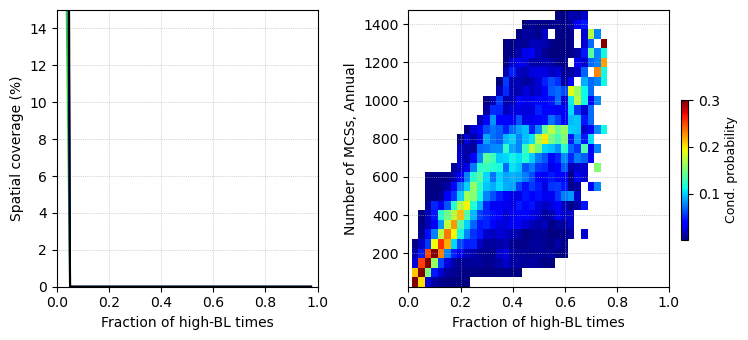

In [24]:
cond_dist_fixedBLF = np.zeros(samples_joint.shape)
MCSnum_fixedBLF = np.zeros(samples_joint.shape[0])
for i in range(cond_dist_fixedBLF.shape[0]):
    cond_dist_fixedBLF[i,:] = samples_joint[i,:]/np.sum(samples_joint[i,:])
    MCSnum_fixedBLF[i] = samples_joint[i,:].sum()
    
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7,3.5))

# scatter plot
ax1.plot(bins_BLF[1:], 100*samples_BLF_land/(samples_BLF_ocean + samples_BLF_land).sum(), '-', color='limegreen')
ax1.plot(bins_BLF[1:], 100*samples_BLF_ocean/(samples_BLF_ocean + samples_BLF_land).sum(), '-', color='b')
ax1.plot(bins_BLF[1:], 100*(samples_BLF_land+samples_BLF_ocean)/(samples_BLF_ocean + samples_BLF_land).sum(), '-k')

# hist2d plot
cp = ax2.pcolormesh(bins_bl[1:], bins_mcs[1:], cond_dist_fixedBLF.T, vmin=0.001, vmax=0.3
                    , cmap='jet', zorder=1)
cp.cmap.set_under('w')
cbaxes = fig.add_axes([0.98, 0.3, 0.01, 0.4])              
cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7)
cbar.set_label('Cond. probability',fontsize=9)

#ax3 = ax2.twinx()
#ax3.plot(bins_bl[1:], MCSnum_fixedBLF, color='k')

ax1.set_xlim([0,1])
ax1.set_ylim([0,15]);
ax2.set_xlim([0,1])
#ax2.set_ylim([0,1500]);
#ax3.set_ylim([0, 20000])
ax1.set_xlabel('Fraction of high-BL times',fontsize=10)
ax1.set_ylabel('Spatial coverage (%)',fontsize=10)
ax2.set_xlabel('Fraction of high-BL times',fontsize=10)
ax2.set_ylabel('Number of MCSs, Annual',fontsize=10)
#ax3.set_ylabel('Total number of MCSs',fontsize=10)
ax1.grid(ls=':',lw=0.5, zorder=1)
ax2.grid(ls=':',lw=0.5, zorder=1)
#ax.set_title('conditional distribution of MCS number', fontsize=10)

plt.tight_layout()

#### Time series of monthly BLF and monthly MCS counts during 2002-2014

In [12]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/')

ds_exceedBLfreq = xr.open_dataset(out_dir / 'counts_map_BLcritval_3hrly.2002.2014.update.nc')
ds_BLF_stack = ds_exceedBLfreq.stack(dims=(['year','month']))/(8*30)
ds_MCS_stack = MCScounts.stack(dims=(['year','month']))/(24*30)

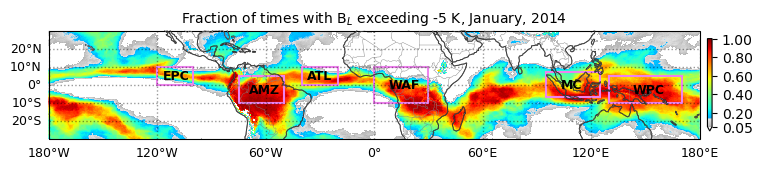

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree()})

total_times = 8*365*13 # 3-hourly, days, 13 years

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'k'}
gl.ylabel_style = {'size': 9, 'color': 'k'}

# plot seasonal mean of BL_TOT as background
cp = ax.pcolormesh(ds_exceedBLfreq.lon, ds_exceedBLfreq.lat, ds_exceedBLfreq.counts.sel(year=2014,month=1)/(8*31),
                 vmin=0.05, vmax=1,
           cmap=mixedmap, transform=ccrs.PlateCarree())
#cf = ax.contour(ds_exceedBLfreq.lon, ds_exceedBLfreq.lat, ds_exceedBLfreq.counts.sel(year=2014,month=1)/(8*31),
#               levels=np.arange(0.5,1.1,0.1), colors=['k'], linewidths=0.5, transform=ccrs.PlateCarree())
#ax.clabel(cf, inline=True, fontsize=6)

cp.cmap.set_under('w')
cbar = plt.colorbar(cp, ax=ax, shrink=0.4, pad=0.01, extend='min')
cbar.set_ticks([0.05, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_title('Fraction of times with B$_{L}$ exceeding -5 K, January, 2014', fontsize=10);

# plot regional boxes 
WPC = [-10,5,130,170]
IND = [-10,5,70,90]
EPC = [0,10,240,260]
ATL = [0,10,320,340]
WAF = [-10,10,0,30]
MC = [-7,7,95,125]
AMZ = [-10,5,285,310]

# rec = Rectangle(xy=(-50,0),width=10,height=10,facecolor='None',edgecolor='r')
# ax.add_patch(rec)

for (geo_info, label_str) in zip([WPC, EPC, ATL, WAF, MC, AMZ],
                                 ['WPC','EPC','ATL','WAF','MC','AMZ']):
    
    if geo_info[2] > 180:
        lon_val = geo_info[2] - 360
    else:
        lon_val = geo_info[2]
    
    rec = Rectangle(xy=(lon_val, geo_info[0]), width=geo_info[3]-geo_info[2],
             height=geo_info[1]-geo_info[0], facecolor='None',edgecolor='violet', lw=1.5)
    ax.add_patch(rec)
    # add labels for regions
    ax.text(x=lon_val+(geo_info[3]-geo_info[2])/2-7, y=geo_info[0]-2+(geo_info[1]-geo_info[0])/2, s=label_str
            , fontsize=9, fontweight='bold')

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/BLcrit_exceed5K_fractionoftimes_Jan2014.pdf', 
#         bbox_inches='tight', transparent=False)

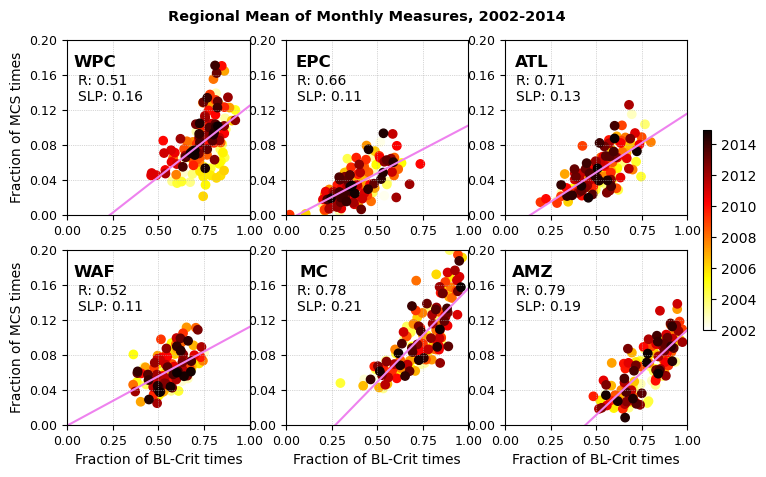

In [15]:
WPC = [-10,5,130,170]
IND = [-10,5,70,90]
EPC = [0,10,240,260]
ATL = [0,10,320,340]
WAF = [-10,10,0,30]
MC = [-7,7,95,125]
AMZ = [-10,5,285,310]

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(8,5))

for (ax, geo_info, label_str) in zip([ax1,ax2,ax3,ax4,ax5,ax6],
                                     [WPC, EPC, ATL, WAF, MC, AMZ],
                                     ['WPC','EPC','ATL','WAF','MC','AMZ']):

    time_color = np.arange(2002,2014.1,0.1)
    
    BLF = ds_BLF_stack.counts.sel(lat=slice(geo_info[0],geo_info[1])
                                , lon=slice(geo_info[2],geo_info[3])).mean(('lon','lat')) # fraction of BL-Crit times
    MCSF = ds_MCS_stack.sel(lat=slice(geo_info[0],geo_info[1])
                                , lon=slice(geo_info[2],geo_info[3])).mean(('lon','lat')) # fraction of MCS times
    
    # linear regression 
    stats = linregress(BLF, MCSF)
    slope = stats[0]
    intercept = stats[1]
    r_val = stats[2] 
    
    cs = ax.scatter(BLF, MCSF, c=np.arange(len(ds_MCS_stack['dims'])), marker='o', label=label_str,
                   cmap='hot_r')
    ax.plot(np.arange(0,1.1,0.1), slope*np.arange(0,1.1,0.1)+intercept, color='violet', lw=1.5)
    #plt.colorbar(cs, ax=ax, shrink=0.7)
    ax.set_xlabel('Fraction of BL-Crit times', fontsize=10)
    ax.set_ylabel('Fraction of MCS times', fontsize=10)
    ax.tick_params(labelsize=9)
    
    ax.set_title(label_str, fontsize=12, fontweight='bold',x=0.15, y=0.8)
    # slope and intercept text
    ax.text(0.06, 0.13, 'R: {}\nSLP: {}'.format(np.round(r_val,2), np.round(slope, 2), fontsize=8))
    
    ax.grid(lw=0.5, ls=':')
    # set x-y bounds
    ax.set_xlim([0,1])
    ax.set_ylim([0,0.2])
    ax.set_yticks(np.arange(0,0.24,0.04))
    
cbaxes = fig.add_axes([0.92, 0.3, 0.01, 0.4])              
cbar = plt.colorbar(cs, cax=cbaxes, shrink=0.7)
cbar.set_ticks(np.arange(0,145,24))
cbar.set_ticklabels(np.arange(2002,2015,2))
    
# remove xlabel 
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')

plt.suptitle('Regional Mean of Monthly Measures, 2002-2014',fontsize=10.5,
            fontweight='bold',y=0.94);

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSF_BLF_scatter_TropicalRegions.pdf',
#          bbox_inches='tight', transparent=False)

In [16]:
BLF = ds_BLF_stack.counts.sel(lat=slice(geo_info[0],geo_info[1])
                            , lon=slice(geo_info[2],geo_info[3]))

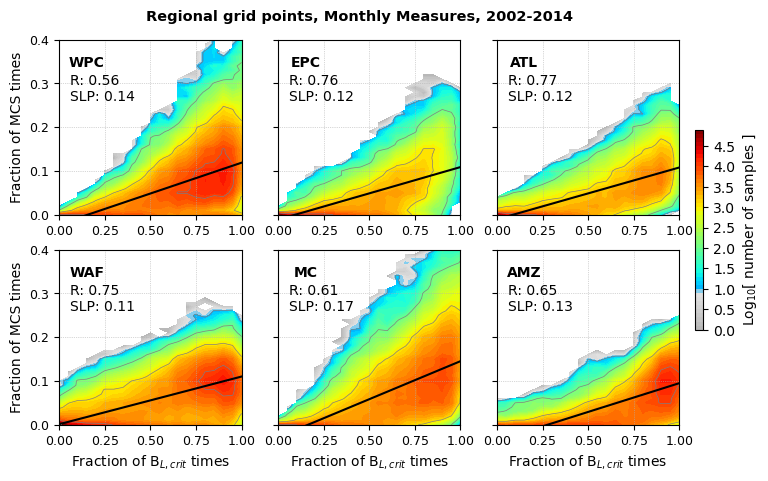

In [60]:
# 2-D histogram of all grid points in the region

WPC = [-10,5,130,170]
IND = [-10,5,70,90]
EPC = [0,10,240,260]
ATL = [0,10,320,340]
WAF = [-10,10,0,30]
MC = [-7,7,95,125]
AMZ = [-10,5,285,310]

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(8,5))

for (ax, geo_info, label_str) in zip([ax1,ax2,ax3,ax4,ax5,ax6],
                                     [WPC, EPC, ATL, WAF, MC, AMZ],
                                     ['WPC','EPC','ATL','WAF','MC','AMZ']):

    time_color = np.arange(2002,2014.1,0.1)
    
    BLF = ds_BLF_stack.counts.sel(lat=slice(geo_info[0],geo_info[1])
                                , lon=slice(geo_info[2],geo_info[3])).values.ravel() # fraction of BL-Crit times
    MCSF = ds_MCS_stack.sel(lat=slice(geo_info[0],geo_info[1])
                                , lon=slice(geo_info[2],geo_info[3])).values.ravel() # fraction of MCS times
    
    # linear regression 
    stats = linregress(BLF, MCSF)
    slope = stats[0]
    intercept = stats[1]
    r_val = stats[2] 
    
    # 2-d histogram
    (samples, bin_xedge, bin_yedge) = np.histogram2d(BLF, MCSF
                                                     , bins=[np.arange(0,1.1,0.05), np.arange(0,0.42,0.01)])
    
    cs = ax.contourf(bin_xedge[:-1], bin_yedge[:-1], np.log10(samples.T), cmap=mixedmap,
                    levels=np.arange(0,5,0.1))
    ax.contour(bin_xedge[:-1], bin_yedge[:-1], np.log10(samples.T), colors=['gray'],
                    levels=[1,2,3,4], linewidths=0.5)
    
    ax.plot(np.arange(0,1.1,0.1), slope*np.arange(0,1.1,0.1)+intercept, color='k', lw=1.5)
    ax.set_xlabel('Fraction of B$_{L,crit}$ times', fontsize=10)
    ax.set_ylabel('Fraction of MCS times', fontsize=10)
    ax.tick_params(labelsize=9)
    
    ax.set_title(label_str, fontsize=10, fontweight='bold',x=0.15, y=0.8)
    # slope and intercept text
    ax.text(0.06, 0.26, 'R: {}\nSLP: {}'.format(np.round(r_val,2), np.round(slope, 2), fontsize=6))
    
    ax.grid(lw=0.5, ls=':')
    # set x-y bounds
    ax.set_xlim([0,1])
    ax.set_ylim([0,0.4])
    #ax.set_yticks(np.arange(0,0.24,0.04))
    
cbaxes = fig.add_axes([0.92, 0.3, 0.01, 0.4])              
cbar = plt.colorbar(cs, cax=cbaxes, shrink=0.7)
cbar.set_label('Log$_{10}$[ number of samples ]')
#cbar.set_ticks(np.arange(0,145,24))
#cbar.set_ticklabels(np.arange(2002,2015,2))
    
# remove xlabel 
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')

ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])

plt.suptitle('Regional grid points, Monthly Measures, 2002-2014',fontsize=10.5,
            fontweight='bold',y=0.94);

fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSF_BLF_hist2d_TropicalRegions.pdf',
         bbox_inches='tight', transparent=False)

#### Trend of FBLC (fraction of critical BL times) 
- period: 2002-2014
- whether fraction of BLC times increases over tropical oceans and land
- whether MCS frequency increases with time because of the increase in the frequency of favorable conditions.

In [ ]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/')

ds_exceedBLfreq = xr.open_dataset(out_dir / 'counts_map_BLcritval_3hrly.2002.2014.update.nc')
ds_BLF_stack = ds_exceedBLfreq.stack(dims=(['year','month']))/(8*30)
ds_MCS_stack = MCScounts.stack(dims=(['year','month']))/(24*30)

In [ ]:
#temp = ds_MCSfreq.counts.polyfit(dim='year', deg=1)
#slope = temp.polyfit_coefficients.sel(degree=1)

# using scipy.linearregress
temp2 = ds_BLF_stack.counts # fraction of BL per month
slope_BLF = np.zeros((temp2.shape[0],temp2.shape[1]))
pval_BLF = np.copy(slope_BLF)

for i,lon in enumerate(temp2.lon):
    for j,lat in enumerate(temp2.lat):
        tmp = temp2.sel(lon=lon, lat=lat)
        stats_out = linregress(x=np.arange(len(tmp)), y=tmp)
        slope_BLF[j,i] = stats_out[0] # slope
        pval_BLF[j,i] = stats_out[3] # p-value

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree(180)})

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'k'}
gl.ylabel_style = {'size': 9, 'color': 'k'}

# plot seasonal mean of BL_TOT as background
cp = ax.pcolormesh(ds_BLF_stack.lon, ds_BLF_stack.lat, 10*12*slope_BLF, 
           cmap='RdBu', transform=ccrs.PlateCarree())

# p-value mask < 0.05
zm = np.ma.masked_greater(pval_BLF, 0.05)
ax.pcolor(ds_BLF_stack.lon, ds_BLF_stack.lat, zm, hatch='...', alpha=0.,
         transform=ccrs.PlateCarree())

cp.cmap.set_under('lightgrey')
cbar = plt.colorbar(cp, ax=ax, shrink=0.4, pad=0.01, extend='both')
cbar.set_label('per decade',fontsize=10)
ax.set_title('Linear regression, Monthly fraction of B$_{L,crit}$ times, 0.25-deg, 2002-2014', fontsize=10);

fig.savefig('/scratch/wmtsai/temp_mcs/fig/BLCfraction_monthly_lineartrend.2002.2014.pdf',
           bbox_inches='tight', transparent=False)

In [ ]:
# using scipy.linearregress
temp2 = ds_MCS_stack.copy()
slope_MCS = np.zeros((temp2.shape[0],temp2.shape[1]))
pval_MCS = np.copy(slope_MCS)

for i,lon in enumerate(temp2.lon):
    for j,lat in enumerate(temp2.lat):
        tmp = temp2.sel(lon=lon, lat=lat)
        stats_out = linregress(x=np.arange(len(tmp)), y=tmp)
        slope_MCS[j,i] = stats_out[0] # slope
        pval_MCS[j,i] = stats_out[3] # p-value

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree(180)})

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'k'}
gl.ylabel_style = {'size': 9, 'color': 'k'}

# plot seasonal mean of BL_TOT as background
cp = ax.pcolormesh(MCScounts.lon, MCScounts.lat, 10*12*slope_MCS, vmin=-0.05, vmax=0.05,
           cmap='RdBu', transform=ccrs.PlateCarree())

# p-value mask < 0.05
zm = np.ma.masked_greater(pval_MCS, 0.05)
ax.pcolor(MCScounts.lon, MCScounts.lat, zm, hatch='...', alpha=0.,
         transform=ccrs.PlateCarree())

cp.cmap.set_under('lightgrey')
cbar = plt.colorbar(cp, ax=ax, shrink=0.4, pad=0.01, extend='both')
cbar.set_label('per decade',fontsize=10)
ax.set_title('Linear regression, Monthly fraction of MCS times, 0.25-deg, 2002-2014', fontsize=10);

fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSfraction_monthly_lineartrend.2002.2014.pdf',
           bbox_inches='tight', transparent=False)